## IT Threat Detection With Similarity Search

This notebook shows how to use Pinecone's similarity search as a service to build an application for detecting rare events. Such application is common in cyber-security and fraud detection domains wherein only a tiny fraction of the events are malicious. 

Here we will build a network intrusion detector. Network intrusion detection systems monitor incoming and outgoing network traffic flow, raising alarms whenever a threat is detected. Here we use a deep-learning model and similarity search in detecting and classifying network intrusion traffic.

We will start by indexing a set of labeled traffic events in the form of vector embeddings. Each event is either benign or malicious. The vector embeddings are rich, mathematical representations of the network traffic events. It is making it possible to determine how similar the network events are to one another using similarity-search algorithms built into Pinecone. Here we will transform network traffic events into vectors using a deep learning model from recent academic work.


We will then take some new (unseen) network events and search through the index to find the most similar matches, along with their labels. In such a way, we will propagate the matched labels to classify the unseen events as benign or malicious. Mind that the intrusion detection task is a challenging classification task because malicious events are sporadic. The similarity search service helps us sift the most relevant historical labeled events. That way, we identify these rare events while keeping a low rate of false alarms. 


## Setting up Pinecone

We will first install and initialize Pinecone. You can get your [API Key here](https://www.pinecone.io/start).

In [1]:
!pip install -qU pinecone-client

In [2]:
import pinecone
import os
# Load Pinecone API key
api_key = os.getenv('PINECONE_API_KEY') or 'YOUR_API_KEY'
pinecone.init(api_key=api_key)
#List all present indexes associated with your key, should be empty on the first run
pinecone.list_indexes()

[]

## Installing other dependencies

In [3]:
!pip install -qU pip python-dateutil tensorflow scikit-learn matplotlib seaborn

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras.models import Model
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

We will use some of the code from a recent [academic work](https://github.com/rambasnet/DeepLearning-IDS). Let's clone the repository that we will use to prepare data.

In [ ]:
!git clone -q https://github.com/rambasnet/DeepLearning-IDS.git 

## Define a New Pinecone Index

In [6]:
# Pick a name for the new service
index_name = 'it-threats'

In [7]:
# Make sure service with the same name does not exist
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

**Create an index**

In [8]:
pinecone.create_index(name=index_name,metric='euclidean', shards=2)

  0%|          | 0/4 [00:00<?, ?it/s]

{'msg': '', 'success': True}

**Connect to the index**

We create an index object, a class instance of pinecone.Index , which will be used to interact with the created index.

In [9]:
index = pinecone.Index(name=index_name, timeout=600)

## Upload
Here we transform network events into vector embeddings, then upload them into Pinecone's vector index. 

### Prepare Data

The datasets we use consist of benign (normal) network traffic and malicious traffic
generated from several different network attacks. We will focus on web attacks only. 

The web attack category consists of three common attacks: 
- Cross-site scripting (BruteForce-XSS), 
- SQL-Injection (SQL-Injection), 
- Brute force administrative and user passwords (BruteForce-Web)

The original data was recorded over two days.

**Download data for 22-02-2018 and 23-02-2018**




Files should be downloaded to the current directory. We will be using one date for training and generating vectors, and another one for testing.

In [10]:
!wget "https://cse-cic-ids2018.s3.ca-central-1.amazonaws.com/Processed%20Traffic%20Data%20for%20ML%20Algorithms/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv" -q --show-progress
!wget "https://cse-cic-ids2018.s3.ca-central-1.amazonaws.com/Processed%20Traffic%20Data%20for%20ML%20Algorithms/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv" -q --show-progress

Thursday-22-02-2018 100%[===================>] 364.91M  89.1MB/s    in 4.4s    
Friday-23-02-2018_T 100%[===================>] 365.10M  86.9MB/s    in 4.6s    


Let's look at the data events first.

In [11]:
data = pd.read_csv('Friday-23-02-2018_TrafficForML_CICFlowMeter.csv')
data.Label.value_counts()

Benign              1048009
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
Name: Label, dtype: int64

**Clean the data** using a python script from the cloned repository.

In [12]:
!python DeepLearning-IDS/data_cleanup.py "Friday-23-02-2018_TrafficForML_CICFlowMeter.csv" "result23022018"

cleaning Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
total rows read = 1048576
all done writing 1042868 rows; dropped 5708 rows


Load the file that you got from the previous step.

In [13]:
data_23_cleaned = pd.read_csv('result23022018.csv')
data_23_cleaned.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6,1.519374e+09,1532698,11,11,1179,1969,648,0,107.181818,196.245162,976,0,179.0,364.186491,2053.894505,14.353774,7.298562e+04,9.751916e+04,207592,11,1532698,153269.8,1.066585e+05,246403,20,1325840,132584.0,106034.780827,247549,67,0,0,0,0,360,360,7.176887,7.176887,0,976,136.869565,282.793903,79972.391304,0,0,0,1,0,0,0,0,1,143.090909,107.181818,179.0,0,0,0,0,0,0,11,1179,11,1969,29200,230,7,32,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
1,500,17,1.519374e+09,117573855,3,0,1500,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,12.757938,0.025516,5.878693e+07,2.375324e+07,75583006,41990849,117573855,58786927.5,2.375324e+07,75583006,41990849,0,0.0,0.000000,0,0,0,0,0,0,24,0,0.025516,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,666.666667,500.000000,0.0,0,0,0,0,0,0,3,1500,0,0,-1,-1,2,8,0.0,0.0,0,0,58786927.5,2.375324e+07,75583006,41990849,Benign
2,500,17,1.519374e+09,117573848,3,0,1500,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,12.757939,0.025516,5.878692e+07,2.375325e+07,75583007,41990841,117573848,58786924.0,2.375325e+07,75583007,41990841,0,0.0,0.000000,0,0,0,0,0,0,24,0,0.025516,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,666.666667,500.000000,0.0,0,0,0,0,0,0,3,1500,0,0,-1,-1,2,8,0.0,0.0,0,0,58786924.0,2.375325e+07,75583007,41990841,Benign
3,22,6,1.519374e+09,1745392,11,11,1179,1969,648,0,107.181818,196.245162,976,0,179.0,364.186491,1803.606296,12.604618,8.311390e+04,1.119720e+05,242608,12,1745392,174539.2,1.211090e+05,275228,20,1509435,150943.5,121013.165836,273442,81,0,0,0,0,360,360,6.302309,6.302309,0,976,136.869565,282.793903,79972.391304,0,0,0,1,0,0,0,0,1,143.090909,107.181818,179.0,0,0,0,0,0,0,11,1179,11,1969,29200,230,7,32,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
4,500,17,1.519374e+09,89483474,6,0,3000,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,33.525744,0.067051,1.789669e+07,1.534523e+07,41989576,4000364,89483474,17896694.8,1.534523e+07,41989576,4000364,0,0.0,0.000000,0,0,0,0,0,0,48,0,0.067051,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,583.333333,500.000000,0.0,0,0,0,0,0,0,6,3000,0,0,-1,-1,5,8,4000364.0,0.0,4000364,4000364,21370777.5,1.528092e+07,41989576,7200485,Benign


In [14]:
data_23_cleaned.Label.value_counts()

Benign              1042301
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
Name: Label, dtype: int64

### Load the Model

Here we load the pretrained model. The model is trained using the data from the same date.

We have modified [the original model](https://github.com/rambasnet/DeepLearning-IDS/blob/master/keras_tensorflow_models/02-23-2018.csv_adam_10_10_multiclass_baseline_model_1561316601.model) slightly and changed the number of classes from four (Benign, BruteForce-Web, BruteForce-XSS, SQL-Injection) to two (Benign and Attack). In the step below we will download and unzip our modified model.

In [ ]:
!wget -q -O it_threat_model.model.zip "https://drive.google.com/uc?export=download&id=1VYMHOk_XMAc-QFJ_8CAPvWFfHnLpS2J_" 
!unzip -q it_threat_model.model.zip


In [16]:
model = keras.models.load_model('it_threat_model.model')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Select the first layer
layer_name = 'dense' 
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

### Upload Data


Let's define the item's ids in a way that will reflect the event's label.  Then, we index the events in Pinecone's vector index.

In [18]:
from tqdm import tqdm
items_to_upload = []

model_res = intermediate_layer_model.predict(K.constant(data_23_cleaned.iloc[:,:-1]))

for i, res in tqdm(zip(data_23_cleaned.iterrows(), model_res), total=len(model_res)):
    benign_or_attack = i[1]['Label'][:3]
    items_to_upload.append((benign_or_attack + '_' + str(i[0]), res))

100%|██████████| 1042867/1042867 [01:34<00:00, 11090.44it/s]


You can lower the NUMBER_OF_ITEMS and, by doing so, limit the number of uploaded items. 

In [19]:
NUMBER_OF_ITEMS = len(items_to_upload)

upsert_acks = index.upsert(items=items_to_upload[:NUMBER_OF_ITEMS])

0it [00:00, ?it/s]

Let's verify all items were inserted. 

In [20]:
index.info()

InfoResult(index_size=1042867)

## Query

First, we will randomly select a Benign/Attack event and query the vector index using the event embedding. Then, we will use data from different day, that contains same set of attacks to query on a bigger sample.


### Evaluate the Rare Event Classification Model

We will use network intrusion dataset for 22-02-2018 for querying and testing the Pinecone.

First, let's clean the data.

In [21]:
!python DeepLearning-IDS/data_cleanup.py "Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv" "result22022018"

cleaning Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
total rows read = 1048576
all done writing 1042966 rows; dropped 5610 rows


In [22]:
data_22_cleaned = pd.read_csv('result22022018.csv')
data_22_cleaned.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6,1.519288e+09,20553406,10,7,1063,1297,744,0,106.3,239.357496,976,0,185.285714,363.396347,1.148228e+02,0.827114,1.284588e+06,4.865569e+06,19526080,12,20553406,2.283712e+06,6.467165e+06,19526080,22,782332,130388.666667,126280.381325,245143,2639,0,0,0,0,212,152,0.486537,0.340576,0,976,131.111111,281.994971,79521.163399,0,0,0,1,0,0,0,0,0,138.823529,106.3,185.285714,0,0,0,0,0,0,10,1063,7,1297,14600,222,4,20,1027304.0,0.0,1027304,1027304,1.952608e+07,0.000000e+00,19526080,19526080,Benign
1,34989,6,1.519288e+09,790,2,0,848,0,848,0,424.0,599.626550,0,0,0.000000,0.000000,1.073418e+06,2531.645570,7.900000e+02,0.000000e+00,790,790,790,7.900000e+02,0.000000e+00,790,790,0,0.000000,0.000000,0,0,1,0,0,0,40,0,2531.645570,0.000000,0,848,565.333333,489.593028,239701.333333,0,1,0,0,1,0,0,0,0,848.000000,424.0,0.000000,0,0,0,0,0,0,2,848,0,0,234,-1,0,20,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign
2,500,17,1.519288e+09,99745913,5,0,2500,0,500,500,500.0,0.000000,0,0,0.000000,0.000000,2.506368e+01,0.050127,2.493648e+07,3.396804e+07,75584115,4000203,99745913,2.493648e+07,3.396804e+07,75584115,4000203,0,0.000000,0.000000,0,0,0,0,0,0,40,0,0.050127,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,600.000000,500.0,0.000000,0,0,0,0,0,0,5,2500,0,0,-1,-1,4,8,4000203.0,0.0,4000203,4000203,3.191524e+07,3.792787e+07,75584115,7200679,Benign
3,500,17,1.519288e+09,99745913,5,0,2500,0,500,500,500.0,0.000000,0,0,0.000000,0.000000,2.506368e+01,0.050127,2.493648e+07,3.396805e+07,75584130,4000189,99745913,2.493648e+07,3.396805e+07,75584130,4000189,0,0.000000,0.000000,0,0,0,0,0,0,40,0,0.050127,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,600.000000,500.0,0.000000,0,0,0,0,0,0,5,2500,0,0,-1,-1,4,8,4000189.0,0.0,4000189,4000189,3.191524e+07,3.792788e+07,75584130,7200693,Benign
4,500,17,1.519288e+09,89481361,6,0,3000,0,500,500,500.0,0.000000,0,0,0.000000,0.000000,3.352654e+01,0.067053,1.789627e+07,1.534519e+07,41990741,4000554,89481361,1.789627e+07,1.534519e+07,41990741,4000554,0,0.000000,0.000000,0,0,0,0,0,0,48,0,0.067053,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,583.333333,500.0,0.000000,0,0,0,0,0,0,6,3000,0,0,-1,-1,5,8,4000554.0,0.0,4000554,4000554,2.137020e+07,1.528109e+07,41990741,7200848,Benign


In [23]:
data_22_cleaned.Label.value_counts()

Benign              1042603
Brute Force -Web        249
Brute Force -XSS         79
SQL Injection            34
Name: Label, dtype: int64

Let's define a sample that will include all different types of web attacks for this specific date.

In [24]:
data_sample = data_22_cleaned[-2000:]
data_sample.Label.value_counts()

Benign              1638
Brute Force -Web     249
Brute Force -XSS      79
SQL Injection         34
Name: Label, dtype: int64

Now, we will query the test dataset and save predicted and expected results to create a confusion matrix.

In [25]:
y_true = []
y_pred = []

BATCH_SIZE = 1000

for i in tqdm(range(0, len(data_sample), BATCH_SIZE)):
    test_data = data_sample.iloc[i:i+BATCH_SIZE, :]
    
    # Create vector embedding using the model
    test_vector = intermediate_layer_model.predict(K.constant(test_data.iloc[:, :-1]))
    
    # Query using the vector embedding
    query_results = index.query(queries=test_vector, top_k=1000)
    
    for label, res in zip(test_data.Label.values, query_results):
        # Add to the true list
        if label == 'Benign':
            y_true.append(0)
        else:
            y_true.append(1)

        counter = Counter(_id.split('_')[0] for _id in res.ids)

        # Add to the predicted list
        if counter['Bru'] or counter['SQL']:
            y_pred.append(1)
        else:
            y_pred.append(0)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

 50%|█████     | 1/2 [00:22<00:22, 22.70s/it]

0it [00:00, ?it/s]

100%|██████████| 2/2 [00:44<00:00, 22.25s/it]


[Text(0, 0.5, 'Benign'), Text(0, 1.5, 'Attack')]

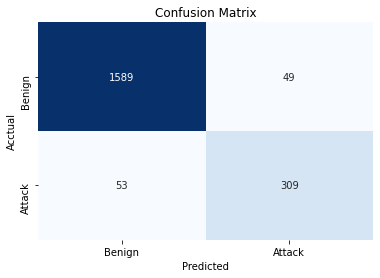

In [26]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show confusion matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap='Blues', fmt='g', cbar=False)

# Add labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Acctual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Benign', 'Attack'])
ax.yaxis.set_ticklabels(['Benign', 'Attack'])

Now we can calculate overall accuracy and per class accuracy.

In [27]:
# Calculate accuracy
acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.949
Precision: 0.863
Recall: 0.854


In [28]:
# Calculate per class accuracy
cmd = confusion_matrix(y_true, y_pred, normalize="true").diagonal()
per_class_accuracy_df = pd.DataFrame([(index, round(value,4)) for index, value in zip(['Benign', 'Attack'], cmd)], columns = ['type', 'accuracy'])
per_class_accuracy_df = per_class_accuracy_df.round(2)
display(per_class_accuracy_df)

,type,accuracy
0,Benign,0.97
1,Attack,0.85


We got great results using Pinecone! Let's see what happens if we skip the similarity search step and predict values from the model directly. In other words, let's use the model that created the embeddings as a classifier. It would be interesting to compare its and the similarity search approach accuracy. 

In [29]:
from keras.utils.np_utils import normalize
import numpy as np

data_sample = normalize(data_22_cleaned.iloc[:, :-1])[-2000:]
y_pred_model = model.predict(normalize(data_sample)).flatten()
y_pred_model = np.round(y_pred_model)

[Text(0, 0.5, 'Benign'), Text(0, 1.5, 'Attack')]

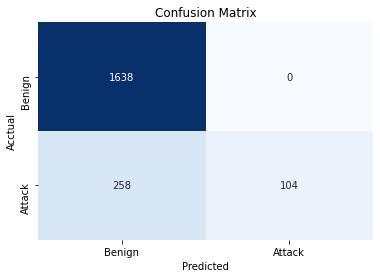

In [30]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_model)

# Show confusion matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap='Blues', fmt='g', cbar=False)

# Add labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Acctual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Benign', 'Attack'])
ax.yaxis.set_ticklabels(['Benign', 'Attack'])

In [31]:
# Calculate accuracy
acc = accuracy_score(y_true, y_pred_model, normalize=True, sample_weight=None)
precision = precision_score(y_true, y_pred_model)
recall = recall_score(y_true, y_pred_model)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.871
Precision: 1.000
Recall: 0.287


In [32]:
# Calculate per class accuracy
cmd = confusion_matrix(y_true, y_pred_model, normalize="true").diagonal()
per_class_accuracy_df = pd.DataFrame([(index, round(value,4)) for index, value in zip(['Benign', 'Attack'], cmd)], columns = ['type', 'accuracy'])
per_class_accuracy_df = per_class_accuracy_df.round(2)
display(per_class_accuracy_df)

,type,accuracy
0,Benign,1.00
1,Attack,0.29


As we can see, the direct application of our model produced much worse results. Pinecone's similarity search over the same model's embeddings improved our threat detection (i.e., "Attack") accuracy by over 50%!

### Result summary

Using standard vector embeddings with Pinecone's similarity search service, we detected 85% of the attacks while keeping a low 3% false-positive rate. We also showed that our similarity search approach outperforms the direct classification approach that utilizes the classifier's embedding model. Similarity search-based detection gained 50% higher accuracy compared to the direct detector.

[Original published results](https://github.com/rambasnet/DeepLearning-IDS/blob/master/graphics/confusion_matrices/) for 02-22-2018 show that the model was able to correctly detect 208520 benign cases out of 208520 benign cases, and 24 (18+1+5) attacks out of 70 attacks in the test set making this model **34.3% accurate in predicting attacks**. For testing purposes, 20% of the data for 02-22-2018 was used. 

![02-22-2018--6-15%281%29.png](https://raw.githubusercontent.com/rambasnet/DeepLearning-IDS/master/graphics/confusion_matrices/02-22-2018--6-15(1).png)

As you can see, the model's performance for creating embeddings for Pinecone was much higher. 

The model we have created follows the academic paper ([model for the same date](https://github.com/rambasnet/DeepLearning-IDS/blob/master/keras_tensorflow_models/) (02-23-2018)) and is slightly modified, but still a straightforward, sequential, shallow model. We have changed the number of classes from four (Benign, BruteForce-Web, BruteForce-XSS, SQL-Injection) to two (Benign and Attack), only interested in whether we are detecting an attack or not. We have also changed validation metrics to precision and recall. These changes improved our results. Yet, there is still room for further improvements, for example, by adding more data covering multiple days and different types of attacks.

## Delete the Index

Delete the index once you are sure that you do not want to use it anymore. Once it is deleted, you cannot reuse it.

In [33]:
pinecone.delete_index(index_name)

  0%|          | 0/1 [00:00<?, ?it/s]

{'success': True}